In [1]:
import numpy as np
import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('legend', fontsize=16, loc='lower left')
plt.rc('figure', titlesize=18)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

In [2]:
from util import generate_fig_name

In [3]:
data_dir = '../data'
data_file = 'zone_temp_exterior_raw.csv'

path_to_data = os.path.join(data_dir, data_file)
data = pd.read_csv(path_to_data, index_col=0)

In [4]:
data.index = pd.to_datetime(data.index)
data.index = data.index.tz_convert("America/Los_Angeles")

data = data.resample('1T').mean()

In [5]:
errors = pd.DataFrame()

for column in data.columns:

    data_groundtruth = data[[column]].dropna()
    
    # creare measurements using different sampling rate
    data_compare = data_groundtruth
    sampleRates = [5, 10, 20, 30, 60, 120]

    for sampleRate in sampleRates:
        measured = data_groundtruth.resample(f'{sampleRate}T').first()
        measured.columns = [f'{sampleRate}min']
        data_compare = pd.concat([data_compare, measured], axis=1)
        
    # fill in using linear interpolation
    for sampleRate in sampleRates:
        data_compare[f'{sampleRate}min'] = data_compare[f'{sampleRate}min'].interpolate()
        error = (((data_compare[f'{sampleRate}min'] - data_compare[column])**2).mean())**0.5
        errors.loc[column, sampleRate] = error    

In [6]:
daily_variation_mean = {}

data['date'] = data.index.date
data['time'] = data.index.time

for sensor_index in data.columns[:-2]:  # exclude the column of date and time
    
    # Reshape the data, dataframe for each sensor, row for date, column for minute of the day
    data_sensor = data[[sensor_index,'date','time']]
    data_daily = data_sensor.pivot_table(index = 'date', 
                                         columns = 'time',
                                         values = sensor_index)
    data_daily.dropna(inplace=True)
    variation_mean = (data_daily.max(axis=1) - data_daily.min(axis=1)).mean()
    
    daily_variation_mean[sensor_index] = variation_mean

daily_variation_mean

{'zone_016_temp': 3.8465454545454567,
 'zone_017_temp': 1.631636363636361,
 'zone_018_temp': 1.646060606060605,
 'zone_019_temp': 3.2895522388059732,
 'zone_021_temp': 2.332324455205812,
 'zone_022_temp': 3.546956521739139,
 'zone_023_temp': 3.0948148148148142,
 'zone_024_temp': 4.171127633209418,
 'zone_025_temp': 2.600746268656716,
 'zone_026_temp': 3.201982651796778,
 'zone_027_temp': 3.445477075588595,
 'zone_028_temp': 4.656788511749339,
 'zone_030_temp': 0.8870967741935495,
 'zone_032_temp': 1.0246268656716417,
 'zone_033_temp': 1.5197802197802224,
 'zone_035_temp': 1.4940606060606063,
 'zone_036_temp': 1.431637717121586,
 'zone_037_temp': 2.7631970260223033,
 'zone_038_temp': 3.0960297766749383,
 'zone_039_temp': 6.548759305210919,
 'zone_040_temp': 4.374177215189864,
 'zone_041_temp': 5.435563816604711,
 'zone_042_temp': 6.134158415841596,
 'zone_043_temp': 4.400619578686497,
 'zone_044_temp': 4.0439119170984466,
 'zone_045_temp': 1.9216981132075555,
 'zone_046_temp': 1.2719512

In [7]:
error_relative = errors.copy(deep=True)

for thermal_zone in error_relative.index:
    error_relative.loc[thermal_zone] = error_relative.loc[thermal_zone]/daily_variation_mean[thermal_zone]

In [8]:
error_relative.head()

,5,10,20,30,60,120
zone_016_temp,0.006386,0.008266,0.010885,0.013371,0.023475,0.051350
zone_017_temp,0.010327,0.014726,0.021161,0.029290,0.040896,0.059649
zone_018_temp,0.010504,0.014802,0.020648,0.025862,0.037608,0.060077
zone_019_temp,0.007422,0.012236,0.021564,0.028001,0.034816,0.047420
zone_021_temp,0.008342,0.011567,0.015339,0.017885,0.022804,0.032576


## Plot typical days

In [10]:
data_dir = '../data'
data_file = 'zone_temp_exterior_raw.csv'

path_to_data = os.path.join(data_dir, data_file)
data = pd.read_csv(path_to_data, index_col=0)

data.index = pd.to_datetime(data.index)
data.index = data.index.tz_convert("America/Los_Angeles")

data = data.resample('1T').mean()

data = pd.DataFrame(columns = data.columns,
                    index = data.index,
                    data = (data.values-32)*5/9,
                    dtype = np.float32)

C:\Users\CEZHEW~1\AppData\Local\Temp/ipykernel_8216/2450396545.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data_array = data.loc[date_start:date_end,sensor_index]
C:\Users\CEZHEW~1\AppData\Local\Temp/ipykernel_8216/2450396545.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data_array = data.loc[date_start:date_end,sensor_index]
C:\Users\CEZHEW~1\AppData\Local\Temp/ipykernel_8216/2450396545.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data_array = data.loc[date_start:date_end,sensor_index]


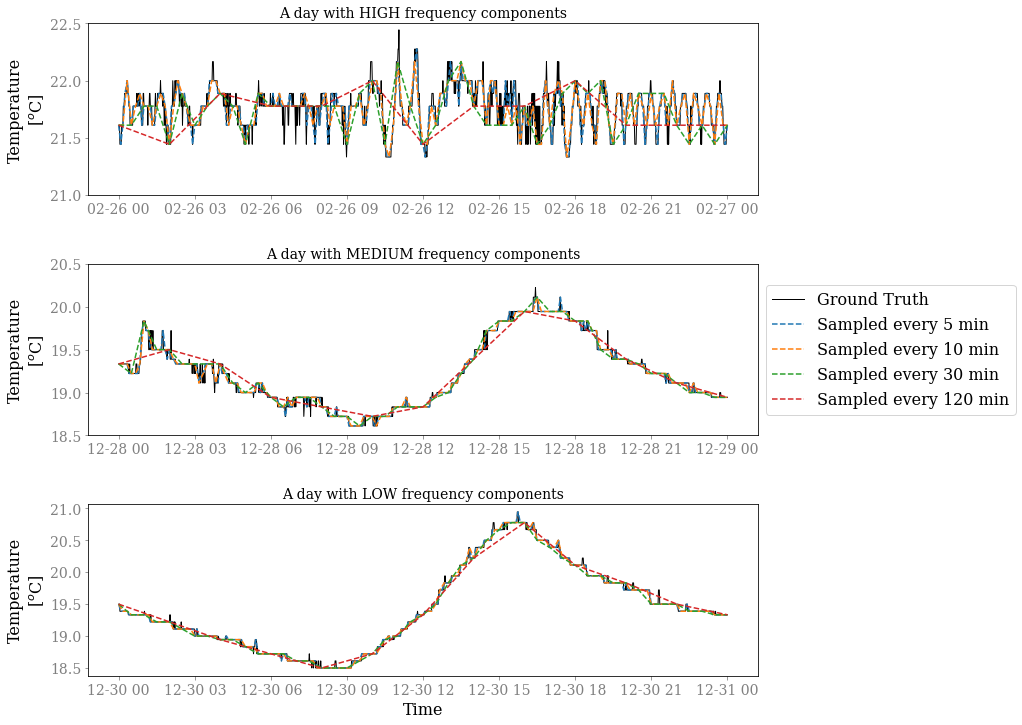

In [11]:
sensor_index = 'zone_028_temp'
sampleRates = [5, 10, 30, 120]

date_starts = {"A day with HIGH frequency components": datetime.date(2019, 2, 26),
               "A day with MEDIUM frequency components": datetime.date(2020, 12, 28),
               "A day with LOW frequency components": datetime.date(2020, 12, 30)}

fig, axs = plt.subplots(3, 1, figsize=(12,12))
plt.subplots_adjust(hspace=0.4)

row_index = 0

for key, date_start in date_starts.items():
    date_end = date_start + datetime.timedelta(days=1)
    data_array = data.loc[date_start:date_end,sensor_index]
    data_groundtruth = data_array.to_frame()
    
    data_groundtruth.columns = ['Ground Truth']
    data_compare = data_groundtruth
   
    axs[row_index].plot(data_groundtruth.index, data_groundtruth.values,label='Ground Truth', linewidth=1, color='k')
    
    for sampleRate in sampleRates:
        measured = data_groundtruth.resample(f'{sampleRate}T').first()
        measured.columns = [f'{sampleRate}min']
        data_compare = pd.concat([data_compare, measured], axis=1)
        data_compare[f'{sampleRate}min'] = data_compare[f'{sampleRate}min'].interpolate()
    
        axs[row_index].plot(data_compare.index, data_compare[f'{sampleRate}min'], '--',label=f'Sampled every {sampleRate} min')

    axs[row_index].set_ylabel('Temperature\n[$^{o}$C]')
    axs[row_index].title.set_text(key)
    axs[row_index].title.set_fontsize(14)
            
    row_index += 1
    
axs[2].set_xlabel('Time')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[0].set_yticks(np.arange(21,23,0.5))
axs[1].set_yticks(np.arange(18.5,21,0.5))
axs[2].set_yticks(np.arange(18.5,21.5,0.5))

plt.savefig(generate_fig_name('typical_day_sampling_rate'))

## Visualize

In [12]:
import seaborn as sns
import matplotlib.ticker as mtick

# reformat the data to use sns plot functions
error_relative_long = pd.melt(error_relative, value_vars=error_relative.columns)
error_relative_long['value'] = error_relative_long['value']*100  # *100 to convert to percentage

error_relative_long.head()

,variable,value
0,5,0.638589
1,5,1.032718
2,5,1.050436
3,5,0.742225
4,5,0.834164


C:\Users\CEZHEW~1\AppData\Local\Temp/ipykernel_8216/452103322.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(generate_fig_name('compare_sampling_rate'), figsize=(7,4))


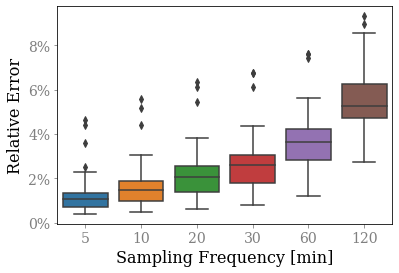

In [13]:
ax = sns.boxplot(x="variable", y="value", data=error_relative_long)  

ax.set_xlabel('Sampling Frequency [min]')
ax.set_ylabel('Relative Error')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(xticks)

plt.savefig(generate_fig_name('compare_sampling_rate'), figsize=(7,4))

In [14]:
highestFreq = pd.read_csv('highestFreq.csv', index_col=0)
highestFreq.columns = ['highestFreq']

highestFreq.head()

,highestFreq
zone_022_temp,2.585278
zone_044_temp,10.152738
zone_058_temp,13.035165
zone_028_temp,13.927253
zone_019_temp,19.775342


In [15]:
error_relative.head()

,5,10,20,30,60,120
zone_016_temp,0.006386,0.008266,0.010885,0.013371,0.023475,0.051350
zone_017_temp,0.010327,0.014726,0.021161,0.029290,0.040896,0.059649
zone_018_temp,0.010504,0.014802,0.020648,0.025862,0.037608,0.060077
zone_019_temp,0.007422,0.012236,0.021564,0.028001,0.034816,0.047420
zone_021_temp,0.008342,0.011567,0.015339,0.017885,0.022804,0.032576


In [16]:
data_plot = pd.merge(error_relative*100,highestFreq, left_index=True, right_index=True)

data_wide = pd.melt(data_plot, id_vars=['highestFreq'], value_vars=error_relative.columns)

data_wide.columns = ['highestFreq', 'Sampling Rate [min]', 'relativeError']

data_wide.head()

,highestFreq,Sampling Rate [min],relativeError
0,86.876471,5,0.638589
1,62.608696,5,1.032718
2,102.857143,5,1.050436
3,19.775342,5,0.742225
4,144.000000,5,0.834164


C:\Users\CEZHEW~1\AppData\Local\Temp/ipykernel_8216/3728225655.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(generate_fig_name('error_sample_rate'), figsize=(10,7))


<Figure size 1080x576 with 0 Axes>

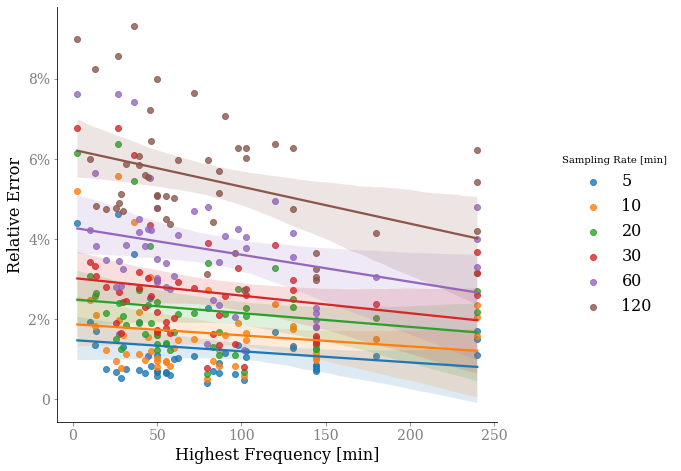

In [17]:
plt.figure(figsize=(15,8))

ax = sns.lmplot(x="highestFreq", y="relativeError", hue='Sampling Rate [min]', data=data_wide)  

plt.xlabel('Highest Frequency [min]')
plt.ylabel('Relative Error')

plt.yticks([0, 2, 4, 6, 8], [0, '2%', '4%', '6%', '8%'])

ax.fig.set_figwidth(10)
ax.fig.set_figheight(7)

plt.savefig(generate_fig_name('error_sample_rate'), figsize=(10,7))